# Regret Heuristics

## Imports

In [1]:
import numpy as np
np.random.seed(42)
import pandas as pd
import math
import seaborn as sns

import matplotlib.pyplot as plt
import matplotlib.cm as cm

## Constants Declarations

In [2]:
TSPA_PATH = "../data/TSPA.csv"
TSPB_PATH = "../data/TSPB.csv"

## Read Data

In [3]:
df = pd.read_csv(TSPA_PATH, sep=";", header=None)
df.columns = ["x", "y", "val"]
df

,x,y,val
0,1355,1796,496
1,2524,387,414
2,2769,430,500
3,3131,1199,1133
4,661,87,903
...,...,...,...
195,189,1151,1145
196,3688,759,727
197,973,984,1637
198,910,1383,1255


## Utils

In [4]:
def math_round(n):
    '''
    Mathematically rounds up to the nearest integer, always rounds up for 0.5

    ParametersL
    n: floating point number to round
    '''
    if n - math.floor(n) < 0.5:
        return math.floor(n)
    return math.ceil(n)

In [5]:
def plot_nodes_with_lines(df, connections=None):
    """
    Plots nodes with optional lines connecting them, using a color scale to represent values.
    
    Parameters:
    df: DataFrame of nodes, each with 'x', 'y', and 'val'.
    connections: list of node indices in the DataFrame to connect in order.
    """
    plt.figure(figsize=(14, 7))
    norm = plt.Normalize(vmin=df.val.min(), vmax=df.val.max())
    colors = cm.Reds(norm(df.val))
    scatter = plt.scatter(df.x, df.y, c=df.val, cmap='Reds', s=100, edgecolors='black')

    if connections is not None:
        for start, end in zip(connections[:-1], connections[1:]):
            plt.plot([df.x[start], df.x[end]], [df.y[start], df.y[end]], color='blue')
        plt.plot([df.x[connections[-1]], df.x[connections[0]]], [df.y[connections[-1]], df.y[connections[0]]], color='blue')
    cbar = plt.colorbar(scatter)
    cbar.set_label('Node Cost')

    plt.xlabel('X')
    plt.ylabel('Y')
    title = 'Nodes with Color-Scaled Values' if connections is None else 'Nodes with Values and Connections'
    plt.title(title)
    plt.grid(False)
    plt.show()


def get_distance_matrix(df, distance_function):
    """
    Calculates the distance matrix for a set of nodes using the given distance function.

    Parameters:
    nodes: DataFrame of nodes, each with 'x', 'y', and 'val'.
    distance_function: function that takes two points (x1, y1) and (x2, y2) and returns the distance.

    Returns:
    A 2D numpy array representing the distance matrix.
    """
    positions = df[["x", "y"]]
    num_nodes = len(positions)
    distance_matrix = np.zeros((num_nodes, num_nodes), dtype=np.int64)

    for i in range(num_nodes):
        for j in range(i, num_nodes):
            dist = round(distance_function(positions.iloc[i], positions.iloc[j]))
            distance_matrix[i, j] = dist
            distance_matrix[j, i] = dist

    return distance_matrix


def calculate_score(solution, matrix, weights):
    '''
    Calculates solution score based on the matrix of distances and provided weights array.

    Parameters:
    solution: List or array of the solution
    matrix: Numpy array with node distances (2D)
    weights: Numpy array with node weights (1D - vector)
    '''
    score = 0
    for i in range(len(solution)-1):
        node_1 = solution[i]
        node_2 = solution[i+1]
        score += (matrix[node_1][node_2] + weights[node_1])
    node_1 = solution[-1]
    node_2 = solution[0]
    score += (matrix[node_1][node_2] + weights[node_1])
    return score

def euclidean_distance(point1, point2):
    return np.linalg.norm(point1 - point2)

In [6]:
def find_second_node_closest(start_node, matrix, weights):
    '''
    Finds the second node for the TSP cycle using a greedy approach, selecting the node closest
    to the start node based on the distance matrix and weights.

    Parameters:
    start_node: int, the index of the node from which the search for the second node starts.
    matrix: numpy.array containing distances between nodes.
    weights: numpy.array containing weights associated with each node.

    Returns:
    second_node: int, the index of the second node selected to form the initial cycle.
    '''
    distance_matrix = np.copy(matrix)
    distance_matrix = distance_matrix.astype(np.float64)
    np.fill_diagonal(distance_matrix, np.inf)
    second_node = np.argmin(distance_matrix[:, start_node] + weights)
    return second_node

def find_second_node_regret(start_node, non_cycle_nodes, matrix, weights):
    '''
    Finds the second node using a regret-based heuristic. The regret is calculated as the difference 
    between the closest and second closest nodes, and the node with the highest regret is selected.

    Parameters:
    start_node: int, the index of the node from which the cycle starts.
    non_cycle_nodes: set of remaining nodes that are not yet in the cycle.
    matrix: numpy.array containing distances between nodes.
    weights: numpy.array containing weights associated with each node.

    Returns:
    best_node: int, the index of the selected second node based on the regret heuristic.
    '''
    distance_matrix = np.copy(matrix)
    distance_matrix = distance_matrix.astype(np.float64)
    best_node = None
    best_regret = -np.inf
    for node in non_cycle_nodes:
        start_node_cost = distance_matrix[start_node][node] + weights[node]
        distance_matrix[start_node][node] = np.inf
        smallest_cost = np.argmin(distance_matrix[node] + weights)
        regret = smallest_cost - start_node_cost
        if regret > best_regret:
            best_regret = regret
            best_node = node
    return best_node

def find_third_node(node_1, node_2, matrix, weights):
    '''
    Finds the third node for the TSP cycle by selecting the node that minimizes the total 
    distance from both the first and second nodes, considering node weights.

    Parameters:
    node_1: int, the index of the first node.
    node_2: int, the index of the second node.
    matrix: numpy.array containing distances between nodes.
    weights: numpy.array containing weights associated with each node.

    Returns:
    third_node: int, the index of the third node to complete the initial triangle of the cycle.
    '''
    distance_matrix = np.copy(matrix)
    distance_matrix = distance_matrix.astype(np.float64)
    np.fill_diagonal(distance_matrix, np.inf)
    third_node = np.argmin(distance_matrix[:, node_1] + distance_matrix[:, node_2] + weights)
    return third_node


def calculate_score_three(solution, matrix, weights):
    '''
    Calculates the score (total distance) for a TSP cycle for the first three nodes. 

    Parameters:
    solution: list of three ints representing the node indices of the current cycle.
    matrix: numpy.array containing distances between nodes.
    weights: numpy.array containing the weights associated with each node.
    '''
    score = 0
    node_1 = solution[0]
    node_2 = solution[1]
    node_3 = solution[2]
    score += matrix[node_1][node_2] + weights[node_1]
    score += matrix[node_2][node_3] + weights[node_2]
    score += matrix[node_3][node_1] + weights[node_3]
    return score

def update_score(solution, score, node, insert_location, matrix, weights):
    '''
    Updates the total score after inserting a node at a specified location in the solution. 

    Parameters:
    solution: List of nodes representing the current cycle.
    score: The current total score (cost) of the cycle before the node is inserted.
    node: int, the node to be inserted into the solution.
    insert_location: int, the index at which the node will be inserted.
    matrix: numpy.array containing distances between nodes.
    weights: numpy.array containing the weights associated with each node.
    '''
    node_before = solution[insert_location - 1]
    node_after = solution[insert_location]
    score -= matrix[node_before][node_after]
    score += matrix[node_before][node] + matrix[node][node_after] + weights[node]
    return score

def find_second_node_closest_weighted(start_node, non_cycle_nodes, matrix, weights, regret_weight):
    '''
    Finds the second node for the TSP cycle using a mix of a weighted greedy and regret approaches
    to the start node based on the distance matrix and weights.

    Parameters:
    start_node: int, the index of the node from which the search for the second node starts.
    matrix: numpy.array containing distances between nodes.
    weights: numpy.array containing weights associated with each node.

    Returns:
    second_node: int, the index of the second node selected to form the initial cycle.
    '''
    distance_matrix = np.copy(matrix)
    distance_matrix = distance_matrix.astype(np.float64)

    greedy_scores = []
    ordered_nodes = list(non_cycle_nodes)
    for node in non_cycle_nodes:
        greedy_score = distance_matrix[start_node][node] + weights[node]
        greedy_scores.append(greedy_score)

    regret_scores = []
    for node in non_cycle_nodes:
        start_node_cost = distance_matrix[start_node][node] + weights[node]
        distance_matrix[start_node][node] = np.inf
        smallest_cost = np.argmin(distance_matrix[node] + weights)
        regret = smallest_cost - start_node_cost
        regret_scores.append(regret)

    greedy_scores = np.array(greedy_scores)
    regret_scores = np.array(regret_scores)
    total_scores = ((1 + regret_weight) * greedy_score) + (regret_weight * regret_scores)
    total_scores, ordered_nodes = zip(*sorted(zip(total_scores, ordered_nodes)))
    return ordered_nodes[0]

In [7]:
distance_matrix = get_distance_matrix(df, euclidean_distance)
pd.DataFrame(distance_matrix)

,0,1,2,3,4,5,6,7,8,9,...,190,191,192,193,194,195,196,197,198,199
0,0,1831,1966,1874,1845,1097,1658,2297,2193,1364,...,1977,746,1414,993,1527,1333,2553,897,607,1100
1,1831,0,249,1014,1887,1985,802,1872,1270,1027,...,2173,2104,2213,2215,1016,2457,1222,1662,1897,2600
2,1966,249,0,850,2136,2209,1050,1698,1066,981,...,2421,2301,2447,2426,1264,2679,976,1880,2089,2796
3,1874,1014,850,0,2709,2513,1715,858,344,512,...,2976,2442,2809,2632,1861,2942,710,2169,2229,2907
4,1845,1887,2136,2709,0,888,1091,3487,3036,2396,...,288,1352,780,1214,874,1164,3101,950,1320,1632
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
195,1333,2457,2679,2942,1164,473,1834,3537,3286,2486,...,1087,587,384,342,1587,0,3521,802,757,523
196,2553,1222,976,710,3101,3068,2023,1124,517,1212,...,3384,3063,3338,3231,2227,3521,0,2724,2847,3545
197,897,1662,1880,2169,950,345,1113,2824,2513,1741,...,1085,529,649,563,890,802,2724,0,404,987
198,607,1897,2089,2229,1320,497,1462,2785,2569,1752,...,1409,216,807,419,1260,757,2847,404,0,708


In [8]:
weights = df.val.to_numpy()
weights[:2]

array([496, 414], dtype=int64)

## Greedy 2-Regret Heuristic

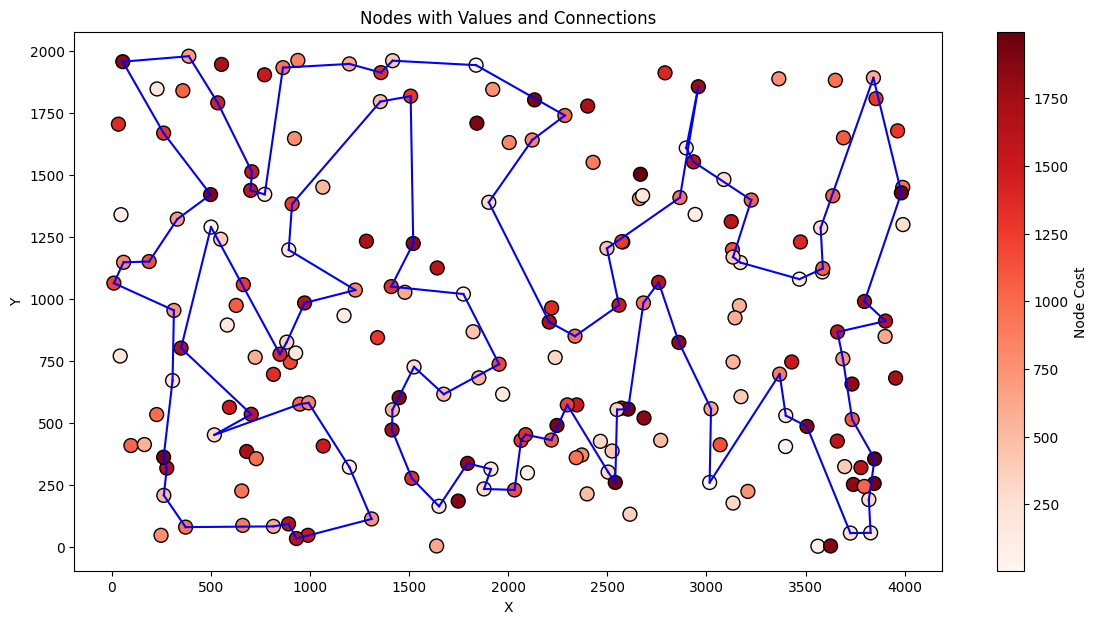

Acheived Total Score: 123037


In [9]:
def greedy_regret_cycle(matrix, weights, start_node):
    '''
    Implements a greedy regret cycle algorithm with regret to solve the Traveling Salesman Problem (TSP).

    Parameters:
    matrix: numpy.array containing distances between nodes.
    weights: numpy.array containing the weights associated with each node.
    starting_node: int, the index of the node from which the cycle starts.
    '''
    solution = [start_node]
    non_cycle_nodes = set([i for i in range(len(weights))])
    non_cycle_nodes.remove(start_node)
    num_iterations = int((len(weights) // 2) - 3)
    second_node = find_second_node_closest(start_node, matrix, weights)
    #second_node = find_second_node_regret(start_node, non_cycle_nodes, matrix, weights)
    solution.append(second_node)
    non_cycle_nodes.remove(second_node)
    third_node = find_third_node(start_node, second_node, matrix, weights)
    solution.append(third_node)
    non_cycle_nodes.remove(third_node)
    score = calculate_score_three(solution, matrix, weights)

    for i in range(num_iterations):
        for node in non_cycle_nodes:
            best_regret = -np.inf
            best_node = None
            best_location = None
            score_locations = []
            scores = []
            for insert_location in range(len(solution) - 1):
                temp_score = update_score(solution, score, node, insert_location, matrix, weights)
                score_locations.append(insert_location)
                scores.append(temp_score)
            scores, score_locations = zip(*sorted(zip(scores, score_locations)))
            regret = scores[1] - scores[0]
            regret_location = score_locations[0]
            if regret > best_regret:
                best_regret = regret
                best_node = node
                best_location = regret_location
        solution.insert(best_location, best_node)
        score = scores[0]
        non_cycle_nodes.remove(best_node)
    return solution, score

start_node = 0
solution, score = greedy_regret_cycle(distance_matrix, weights, start_node)
plot_nodes_with_lines(df, solution)
print(f"Acheived Total Score: {score}")

## Greedy Weighted 2-Regret Heuristic

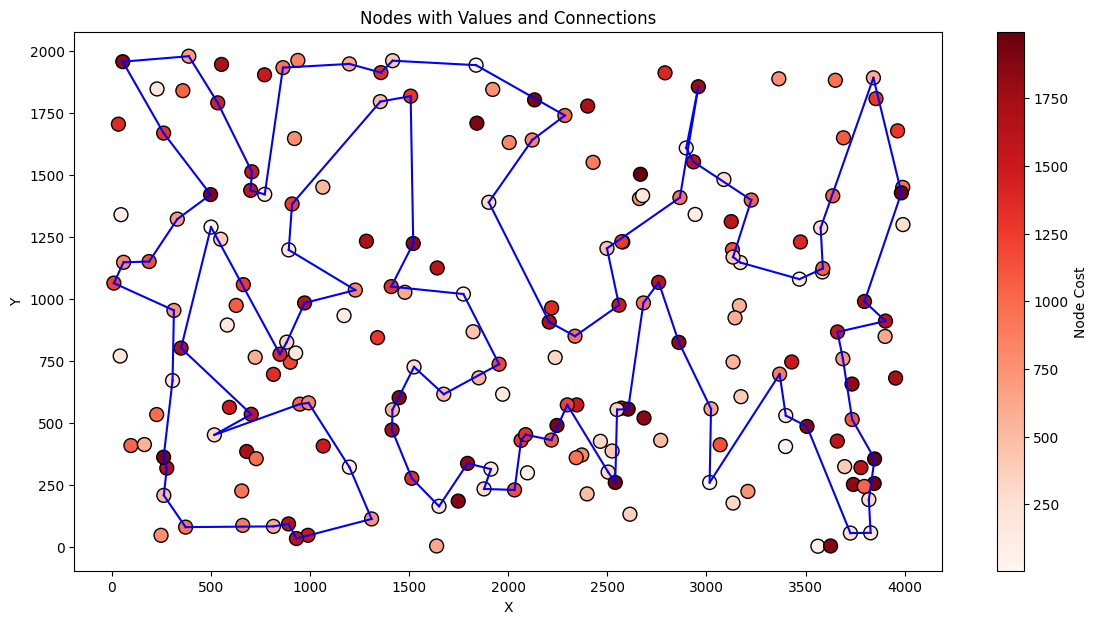

Acheived Total Score: 123037


In [10]:
def greedy_regret_cycle_weighted(matrix, weights, start_node, regret_weight=-0.5):
    '''
    Implements a weighted greedy cycle algorithm with regret to solve the Traveling Salesman Problem (TSP).

    Parameters:
    matrix: numpy.array containing distances between nodes.
    weights: numpy.array containing the weights associated with each node.
    starting_node: int, the index of the node from which the cycle starts.
    '''
    solution = [start_node]
    non_cycle_nodes = set([i for i in range(len(weights))])
    non_cycle_nodes.remove(start_node)
    num_iterations = int((len(weights) // 2) - 3)
    second_node = find_second_node_closest_weighted(start_node, non_cycle_nodes, matrix, weights, regret_weight)
    solution.append(second_node)
    non_cycle_nodes.remove(second_node)
    third_node = find_third_node(start_node, second_node, matrix, weights)
    solution.append(third_node)
    non_cycle_nodes.remove(third_node)
    score = calculate_score_three(solution, matrix, weights)

    for i in range(num_iterations):
        for node in non_cycle_nodes:
            best_weighted_score = np.inf
            best_score = None
            best_node = None
            best_location = None
            score_locations = []
            scores = []
            for insert_location in range(len(solution) - 1):
                temp_score = update_score(solution, score, node, insert_location, matrix, weights)
                score_locations.append(insert_location)
                scores.append(temp_score)
            scores, score_locations = zip(*sorted(zip(scores, score_locations)))
            regret = scores[1] - scores[0]
            regret_location = score_locations[0]
            weghted_score = ((1 + regret_weight) * scores[0]) + (regret_weight * regret)
            if weghted_score < best_weighted_score:
                best_weighted_score = weghted_score
                best_node = node
                best_location = regret_location
                best_score = scores[0]
        solution.insert(best_location, best_node)
        score = best_score
        non_cycle_nodes.remove(best_node)
    return solution, score

start_node = 0
solution, score = greedy_regret_cycle_weighted(distance_matrix, weights, start_node)
plot_nodes_with_lines(df, solution)
print(f"Acheived Total Score: {score}")

## Experiments

In [11]:
def test_algorithm(algorithm, distance_matrix, weights, num_runs = 200, random = False):
    '''
    Tests chosen algorithm for each node run num_runs times.

    Parameters:
    algorithm: Function to test
    distance_matrix: numpy.array containing distances between nodes.
    weights: numpy.array containing the weights associated with each node.
    num_runs: integer, number of tests per node (default: 200)
    '''
    all_nodes = [i for i in range(len(weights))]
    if random:
        results = {node: [] for node in all_nodes}
        solutions = {node: [] for node in all_nodes}
        for node in all_nodes:
            for i in range(num_runs):
                solution, score = algorithm(distance_matrix, weights, node)
                solutions[node].append(solution)
                results[node].append(score)
    else:
        results = {}
        solutions = {}
        for node in all_nodes:
            solution, score = algorithm(distance_matrix, weights, node)
            solutions[node] = solution
            results[node] = score
    return solutions, results

In [12]:
del df
del weights
del distance_matrix

### Instance A

In [13]:
df_A = pd.read_csv(TSPA_PATH, sep=";", header=None)
df_A.columns = ["x", "y", "val"]
distance_matrix = get_distance_matrix(df_A, euclidean_distance)
weights_A = df_A.val.to_numpy()

In [14]:
greedy_regret_cycle_solutions_A, greedy_regret_cycle_results_A = test_algorithm(greedy_regret_cycle, distance_matrix, weights_A, random=True)

NameError: name 'weights' is not defined

In [ ]:
weighted_cycle_solutions_A, weighted_cycle_results_A = test_algorithm(greedy_regret_cycle_weighted, distance_matrix, weights_A)

### Instance B

In [ ]:
df_B = pd.read_csv(TSPB_PATH, sep=";", header=None)
df_B.columns = ["x", "y", "val"]
distance_matrix = get_distance_matrix(df_B, euclidean_distance)
weights_B = df_B.val.to_numpy()

In [ ]:
greedy_regret_cycle_solutions_B, greedy_regret_cycle_results_B = test_algorithm(greedy_regret_cycle, distance_matrix, weights_B, random=True)

In [ ]:
weighted_cycle_solutions_B, weighted_cycle_results_B = test_algorithm(greedy_regret_cycle_weighted, distance_matrix, weights_B)

## Results - Instance A

In [ ]:
def plot_nodes_with_lines_and_score(df, score, connections=None):
    """
    Plots nodes with optional lines connecting them, using a color scale to represent values.
    
    Parameters:
    df: DataFrame of nodes, each with 'x', 'y', and 'val'.
    connections: list of node indices in the DataFrame to connect in order.
    """
    plt.figure(figsize=(14, 7))
    norm = plt.Normalize(vmin=df.val.min(), vmax=df.val.max())
    colors = cm.Reds(norm(df.val))
    scatter = plt.scatter(df.x, df.y, c=df.val, cmap='Reds', s=100, edgecolors='black')

    if connections is not None:
        for start, end in zip(connections[:-1], connections[1:]):
            plt.plot([df.x[start], df.x[end]], [df.y[start], df.y[end]], color='blue')
        plt.plot([df.x[connections[-1]], df.x[connections[0]]], [df.y[connections[-1]], df.y[connections[0]]], color='blue')
    cbar = plt.colorbar(scatter)
    cbar.set_label('Node Cost')

    plt.xlabel('X')
    plt.ylabel('Y')
    title = f'Nodes with Color-Scaled Values, Score: {score}' if connections is None else f'Nodes with Color-Scaled Values, Score: {score}'
    plt.title(title)
    plt.grid(False)
    plt.show()

def plot_score_distribution(score_dict, label):
    all_scores = []
    for key in score_dict.keys():
        for item in score_dict[key]:
            all_scores.append(item)
    plt.hist(all_scores, bins=30, density=True, edgecolor='black', color="black", alpha=0.7)
    plt.title(f'Distribution of Scores Across All Nodes For {label}')
    plt.xlabel('Score Value')
    plt.ylabel('Relative Frequency')
    plt.show()

def plot_score_distribution_not_random(score_dict, label):
    all_scores = []
    for key in score_dict.keys():
        item = score_dict[key]
        all_scores.append(item)
    plt.hist(all_scores, bins=30, density=True, edgecolor='black', color="black", alpha=0.7)
    plt.title(f'Distribution of Scores Across All Nodes For {label}')
    plt.xlabel('Score Value')
    plt.ylabel('Relative Frequency')
    plt.show()

def plot_distribution_node(score_dict, node, label):
    all_scores = score_dict[node]
    plt.hist(all_scores, bins=30, density=True, edgecolor='black', color="black", alpha=0.7)
    plt.title(f'Distribution of Scores For {node} Node For {label}')
    plt.xlabel('Score Value')
    plt.ylabel('Relative Frequency')
    plt.show()

def plot_score_distributions(score_dict_1, score_dict_2, labels):
    all_scores_1 = []
    for key in score_dict_1.keys():
        item = score_dict_1[key]
        all_scores_1.append(item)

    all_scores_2 = []
    for key in score_dict_2.keys():
        item = score_dict_2[key]
        all_scores_2.append(item)
    
    plt.figure(figsize=(10, 6))
    
    sns.kdeplot(all_scores_1, label=labels[0], color='black', linewidth=2)
    sns.kdeplot(all_scores_2, label=labels[1], color='red', linewidth=2)
    plt.xscale('log')
    
    # Add titles and labels
    plt.title('Continuous Distribution of Scores Across Different Nodes', fontsize=14)
    plt.xlabel('Score Value', fontsize=12)
    plt.ylabel('Density', fontsize=12)
    plt.legend(loc='upper right')
    plt.show()


def plot_worst_overall(df, solutions, results):
    all_scores = []
    for key in results.keys():
        for item in results[key]:
            all_scores.append(item)
    
    all_solutions = []
    for key in solutions.keys():
        for item in solutions[key]:
            all_solutions.append(item)
    
    all_scores = np.array(all_scores)
    best_overall = np.argmax(all_scores)
    best_solution = all_solutions[best_overall]
    plot_nodes_with_lines_and_score(df, all_scores[best_overall], best_solution)

def plot_worst_for_node(df, solutions, results, node):
    all_solutions = solutions[node]
    all_results = np.array(results[node])
    best_solution = all_solutions[np.argmax(all_results)]
    plot_nodes_with_lines_and_score(df, all_results[np.argmax(all_results)], best_solution)

def plot_average_overall(df, solutions, results):
    all_scores = []
    for key in results.keys():
        for item in results[key]:
            all_scores.append(item)
    
    all_solutions = []
    for key in solutions.keys():
        for item in solutions[key]:
            all_solutions.append(item)

    all_scores = np.array(all_scores)
    median_index = np.argsort(all_scores)[len(all_scores) // 2]
    median_solution = all_solutions[median_index]
    plot_nodes_with_lines_and_score(df, all_scores[median_index], median_solution)
    
def plot_average_for_node(df, solutions, results, node):
    all_solutions = solutions[node]
    all_scores = results[node]
    all_scores = np.array(all_scores)
    median_index = np.argsort(all_scores)[len(all_scores) // 2]
    median_solution = all_solutions[median_index]
    plot_nodes_with_lines_and_score(df, all_scores[median_index], median_solution)

def plot_best_overall(df, solutions, results):
    all_scores = []
    for key in results.keys():
        for item in results[key]:
            all_scores.append(item)
    
    all_solutions = []
    for key in solutions.keys():
        for item in solutions[key]:
            all_solutions.append(item)
    
    all_scores = np.array(all_scores)
    best_overall = np.argmin(all_scores)
    best_solution = all_solutions[best_overall]
    plot_nodes_with_lines_and_score(df, all_scores[best_overall], best_solution)

def plot_best_for_node(df, solutions, results, node):
    all_solutions = solutions[node]
    all_results = np.array(results[node])
    best_solution = all_solutions[np.argmin(all_results)]
    plot_nodes_with_lines_and_score(df, all_results[np.argmin(all_results)], best_solution)

def calculate_stats_overall(results):
    all_scores = []
    for key in results.keys():
        for item in results[key]:
            all_scores.append(item)
    all_scores = np.array(all_scores)
    min_value = np.min(all_scores)
    max_value = np.max(all_scores)
    median_value = np.median(all_scores)
    mean_value = np.mean(all_scores)
    std_deviation = np.std(all_scores)
    return min_value, max_value, median_value, mean_value, std_deviation

def calculate_stats_node(results, node):
    all_scores = np.array(results[node])
    min_value = np.min(all_scores)
    max_value = np.max(all_scores)
    median_value = np.median(all_scores)
    mean_value = np.mean(all_scores)
    std_deviation = np.std(all_scores)
    return min_value, max_value, median_value, mean_value, std_deviation

def summarize_results(results_1, results_2):
    total_results= {}
    comparison_regret = {}
    comparison_weighted = {}

    for node in results_1.keys():
        scores = np.array(results_1[node])
        comparison_regret[node] = {"Best Score:" : np.min(scores),
                            "Worst Score:" : np.max(scores),
                            "Median Score:" : np.median(scores),
                            "Average Score" : np.mean(scores)}
    
    for node in results_2.keys():
        scores = np.array([results_2[node]])
        comparison_weighted[node] = {"Best Score:" : np.min(scores),
                            "Worst Score:" : np.max(scores),
                            "Median Score:" : np.median(scores),
                            "Average Score" : np.mean(scores)}
    
    labels = ["Greedy Regret", "Weighted Greedy"]
    for node in results_1.keys():
        scores_1 = np.array(results_1[node])
        scores_2 = np.array([results_2[node]])

        max_1 = np.max(scores_1)
        max_2 = np.max(scores_2)

        min_1 = np.min(scores_1)
        min_2 = np.min(scores_2)

        avr_1 = np.mean(scores_1)
        avr_2 = np.mean(scores_2)
        
        median_1 = np.median(scores_1)
        median_2 = np.median(scores_2)

        maxs = np.array([max_1, max_2])
        mins = np.array([min_1, min_2])
        means = np.array([avr_1, avr_2])
        medians = np.array([median_1, median_2])
        
        total_results[node] = {"Best Maximum Score" : labels[np.argmin(maxs)],
                               "Best Minimum Score" : labels[np.argmin(mins)],
                               "Best Average Score" : labels[np.argmin(means)],
                               "Best Median Score" : labels[np.argmin(medians)]

        }

    return pd.DataFrame(comparison_regret), pd.DataFrame(comparison_weighted), pd.DataFrame(total_results)

In [ ]:
def plot_best_overall_not_random(df, solutions, results):
    all_scores = []
    for key in results.keys():
        item = results[key]    
        all_scores.append(item)
    
    all_solutions = []
    for key in solutions.keys():
        item = solutions[key]
        all_solutions.append(item)
    
    all_scores = np.array(all_scores)
    best_overall = np.argmin(all_scores)
    best_solution = all_solutions[best_overall]
    print("___________________________________________________________________")
    print(f"For Node: {best_overall}")
    plot_nodes_with_lines_and_score(df, all_scores[best_overall], best_solution)

def plot_average_overall_not_random(df, solutions, results):
    all_scores = []
    for key in results.keys():
        item = results[key]    
        all_scores.append(item)
    
    all_solutions = []
    for key in solutions.keys():
        item = solutions[key]
        all_solutions.append(item)

    all_scores = np.array(all_scores)
    median_index = np.argsort(all_scores)[len(all_scores) // 2]
    median_solution = all_solutions[median_index]
    
    print("___________________________________________________________________")
    print(f"For Node: {median_index}")
    plot_nodes_with_lines_and_score(df, all_scores[median_index], median_solution)

def plot_worst_overall_not_random(df, solutions, results):
    all_scores = []
    for key in results.keys():
        item = results[key]    
        all_scores.append(item)
    
    all_solutions = []
    for key in solutions.keys():
        item = solutions[key]
        all_solutions.append(item)
    
    all_scores = np.array(all_scores)
    best_overall = np.argmax(all_scores)
    best_solution = all_solutions[best_overall]
    print("___________________________________________________________________")
    print(f"For Node: {best_overall}")
    plot_nodes_with_lines_and_score(df, all_scores[best_overall], best_solution)


def calculate_stats_overall_not_random(results):
    all_scores = []
    for key in results.keys():
        all_scores.append(results[key])
    all_scores = np.array(all_scores)
    min_value = np.min(all_scores)
    max_value = np.max(all_scores)
    median_value = np.median(all_scores)
    mean_value = np.mean(all_scores)
    std_deviation = np.std(all_scores)
    return min_value, max_value, median_value, mean_value, std_deviation


def plot_node(df, scores, solutions, node):
    score = scores[node]
    connections = solutions[node]
    print(f"Plotting Node: {node}")
    plot_nodes_with_lines_and_score(df, score, connections)

In [ ]:
plot_score_distribution_not_random(greedy_regret_cycle_results_A, label="NN All")
plot_best_overall_not_random(df_A, greedy_regret_cycle_solutions_A, greedy_regret_cycle_results_A)
plot_node(df_A, greedy_regret_cycle_results_A, greedy_regret_cycle_solutions_A, node=0)
plot_average_overall_not_random(df_A, greedy_regret_cycle_solutions_A, greedy_regret_cycle_results_A)
plot_worst_overall_not_random(df_A, greedy_regret_cycle_solutions_A, greedy_regret_cycle_results_A)
min_value, max_value, median_value, mean_value, std_deviation = calculate_stats_overall_not_random(greedy_regret_cycle_results_A)
print(f"Overall Stats: \n Minimum: {min_value} Maximum: {max_value} Median: {median_value} Mean: {mean_value} Standard Deviation: {std_deviation}")

In [ ]:
plot_score_distribution_not_random(weighted_cycle_results_A, label="NN All")
plot_best_overall_not_random(df_A, weighted_cycle_solutions_A, weighted_cycle_results_A)
plot_node(df_A, weighted_cycle_results_A, weighted_cycle_solutions_A, node=0)
plot_average_overall_not_random(df_A, weighted_cycle_solutions_A, weighted_cycle_results_A)
plot_worst_overall_not_random(df_A, weighted_cycle_solutions_A, weighted_cycle_results_A)
min_value, max_value, median_value, mean_value, std_deviation = calculate_stats_overall_not_random(weighted_cycle_results_A)
print(f"Overall Stats: \n Minimum: {min_value} Maximum: {max_value} Median: {median_value} Mean: {mean_value} Standard Deviation: {std_deviation}")

## Results - Instance B

In [ ]:
plot_score_distribution_not_random(greedy_regret_cycle_results_B, label="NN All")
plot_best_overall_not_random(df_B, greedy_regret_cycle_solutions_B, greedy_regret_cycle_results_B)
plot_node(df_B, greedy_regret_cycle_results_B, greedy_regret_cycle_solutions_B, node=0)
plot_average_overall_not_random(df_B, greedy_regret_cycle_solutions_B, greedy_regret_cycle_results_B)
plot_worst_overall_not_random(df_B, greedy_regret_cycle_solutions_B, greedy_regret_cycle_results_B)
min_value, max_value, median_value, mean_value, std_deviation = calculate_stats_overall_not_random(greedy_regret_cycle_results_B)
print(f"Overall Stats: \n Minimum: {min_value} Maximum: {max_value} Median: {median_value} Mean: {mean_value} Standard Deviation: {std_deviation}")

In [ ]:
plot_score_distribution_not_random(weighted_cycle_results_B, label="NN All")
plot_best_overall_not_random(df_B, weighted_cycle_solutions_B, weighted_cycle_results_B)
plot_node(df_B, weighted_cycle_results_B, weighted_cycle_solutions_B, node=0)
plot_average_overall_not_random(df_B, weighted_cycle_solutions_B, weighted_cycle_results_B)
plot_worst_overall_not_random(df_B, weighted_cycle_solutions_B, weighted_cycle_results_B)
min_value, max_value, median_value, mean_value, std_deviation = calculate_stats_overall_not_random(weighted_cycle_results_B)
print(f"Overall Stats: \n Minimum: {min_value} Maximum: {max_value} Median: {median_value} Mean: {mean_value} Standard Deviation: {std_deviation}")

### All

In [ ]:
comparison_regret, comparison_weighted, total_results  = summarize_results(greedy_regret_cycle_results_B, weighted_cycle_results_B)
comparison_regret

In [ ]:
comparison_weighted

In [ ]:
total_results

In [ ]:
total_results

In [ ]:
plot_score_distributions(greedy_regret_cycle_results_B, weighted_cycle_results_B, ["Greedy Regret", "Weighted Greedy"])

## Comparing Both Instances

In [ ]:
def plot_all_distributions(score_dict_1, score_dict_2, score_dict_3, score_dict_4):
    all_scores_1 = []
    for key in score_dict_1.keys():
        item = score_dict_1[key]
        all_scores_1.append(item)

    all_scores_2 = []
    for key in score_dict_2.keys():
        item = score_dict_2[key]
        all_scores_2.append(item)

    all_scores_3 = []
    for key in score_dict_3.keys():
        item = score_dict_3[key]
        all_scores_3.append(item)

    all_scores_4 = []
    for key in score_dict_4.keys():
        item = score_dict_4[key]
        all_scores_4.append(item)
    
    plt.figure(figsize=(18, 12))

    all_scores_1 = np.array(all_scores_1)
    all_scores_2 = np.array(all_scores_2)
    all_scores_3 = np.array(all_scores_3)
    all_scores_4 = np.array(all_scores_4)

    to_plot = [np.mean(all_scores_1), np.mean(all_scores_2), np.mean(all_scores_3), np.mean(all_scores_4)]
    labels = ["Greedy Regret A", "Weighted Greedy A", "Greedy Regret B", "Weighted Greedy B"]
    sorted_indices = np.argsort(to_plot)[::-1]
    to_plot_sorted = np.array(to_plot)[sorted_indices]
    labels_sorted = np.array(labels)[sorted_indices]

    # Plotting the bar chart
    plt.figure(figsize=(12, 5))
    plt.yscale('log')
    plt.bar(labels_sorted, to_plot_sorted, color=['blue', 'red', 'green', 'black'])

    # Adding title and labels
    plt.title('Comparison of Mean Scores Across Different TSP Algorithms', fontsize=14)
    plt.xlabel('TSP Algorithms', fontsize=12)
    plt.xticks(rotation=45, ha='right')
    plt.ylabel('Mean Score Logarithmic Scale)', fontsize=12)

In [ ]:
plot_all_distributions(greedy_regret_cycle_results_A, weighted_cycle_results_A, greedy_regret_cycle_results_B, weighted_cycle_results_B)